# Solving adjoint equations using `firedrake-adjoint`

This notebook demonstrates how to use `firedrake-adjoint` to solve an adjoint equation and extract the solution thereof.

Suppose we have a PDE in 'residual form'

$$F(u)=0,\quad u\in V,$$

for some function space $V$.
Given an objective functional $J:V\rightarrow\mathbb R$, the adjoint equation is given by

$$\frac{\partial F}{\partial u}^T\lambda=\frac{\partial J}{\partial u}^T,\quad\lambda\in V.$$

We seek to compute the adjoint solution, $\lambda$.

Suppose the PDE involves a parameter $\nu$ which is defined as a Firedrake `Constant` or `Function` (rather than a float).
Then `firedrake-adjoint` enables us to compute the gradient $\mathrm dJ/\mathrm d\nu$.
Whilst we might not actually need this for our application, performing the computation endows the `SolveVarFormBlock`s with adjoint solutions.
Why is that?

Taking the transpose of the adjoint equation gives

$$\frac{\partial J}{\partial u}=\lambda^T\frac{\partial F}{\partial u}.$$

Now, expanding the gradient $\mathrm dJ/\mathrm d\nu$ using the chain rule gives

$$
\frac{\mathrm dJ}{\mathrm d\nu}
=\frac{\partial J}{\partial u}\frac{\mathrm du}{\mathrm d\nu}+\frac{\partial J}{\partial\nu}
=\lambda^T\frac{\partial F}{\partial u}\frac{\mathrm du}{\mathrm d\nu}+\frac{\partial J}{\partial\nu}
=\lambda^T\frac{\partial F}{\partial\nu}+\frac{\partial J}{\partial\nu}
$$

So in order to compute the gradient $\mathrm dJ/\mathrm d\nu$, it is sufficient to evaluate:
1. the adjoint solution, $\lambda$;
2. the _partial_ derivative of the PDE residual w.r.t. the parameter $\nu$;
3. the _partial_ derivative of the objective functional w.r.t. $\nu$.

In order to compute the gradient, `firedrake-adjoint` does all three of these things.
The two partial derivatives can be straightforwardly computed using the automatic differentiation functionality of UFL, as we shall see.

## The forward problem

Import Firedrake with adjoint mode activated.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from firedrake import *
from firedrake_adjoint import *

Setup a finite element discretisation of Burgers equation in $\mathbb P2$ space as in the [Firedrake demo](https://firedrakeproject.org/demos/burgers.py.html).

In [2]:
# Define a simple mesh
n = 32
mesh = UnitSquareMesh(n, n)

# Define P2 function space and corresponding test function
V = VectorFunctionSpace(mesh, "CG", 2)
v = TestFunction(V)

# Create Functions for the solution and time-lagged solution
u = Function(V, name="Velocity")
u_ = Function(V)

# Assign initial condition
x, y = SpatialCoordinate(mesh)
u_ = interpolate(as_vector([sin(pi*x), 0]), V)
u.assign(u_)

# Set diffusivity constant
nu = Constant(0.0001)

# Define nonlinear form
dt = 1.0/n
F = (inner((u - u_)/dt, v) + inner(dot(u, nabla_grad(u)), v) + nu*inner(grad(u), grad(v)))*dx

Having set up the bilinear form `F`, we are able to:

* compute weak solutions of the PDE;

* evaluate the partial derivative $\frac{\partial F}{\partial\nu}$.

In [3]:
# Timestepping details
end_time = 0.5
timesteps_per_export = 4
num_timesteps = int(end_time/dt)
num_exports = num_timesteps//timesteps_per_export

# Store forward solution and ∂F/∂ν at exports so we can plot again later
forward_solutions = [u.copy(deepcopy=True), ]
dFdnu = [assemble(derivative(F, nu, nu), annotate=False), ]

# Time integrate
i = 0
t = 0.0
while (t < end_time):
    solve(F == 0, u)
    u_.assign(u)
    t += dt
    i += 1
    if i % timesteps_per_export == 0:
        forward_solutions.append(u.copy(deepcopy=True))
        dFdnu.append(assemble(derivative(F, nu, nu), annotate=False))

Plot solution and $\partial F/\partial\nu$ at each export timestep.

<IPython.core.display.Javascript object>


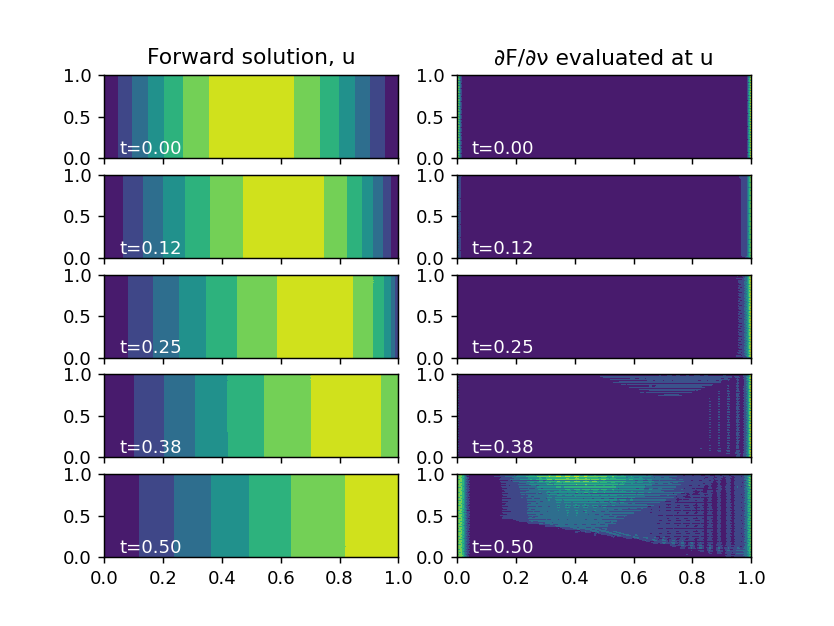

In [4]:
fig, axs = plt.subplots(num_exports+1, 2, sharex='col')

for i in range(len(forward_solutions)):
    tricontourf(forward_solutions[i], axes=axs[i, 0])
    tricontourf(dFdnu[i], axes=axs[i, 1])
    axs[i, 0].annotate('t={:.2f}'.format(i*timesteps_per_export*dt), (0.05, 0.05), color='white');
    axs[i, 1].annotate('t={:.2f}'.format(i*timesteps_per_export*dt), (0.05, 0.05), color='white');
axs[0, 0].set_title('Forward solution, u');
axs[0, 1].set_title('∂F/∂ν evaluated at u');

## The objective functional

In order to solve the adjoint equation, we need an objective functional. For this example, consider the following integral over the 'upstream boundary' at the final time $T$:

$$J(u)=\int_{\Gamma_2}u|_{t=T}\cdot u_{t=T}\;\mathrm ds,
\quad\quad\Gamma_2=\{(1,y)\mid y\in(0,1)\}.$$

In [5]:
J_form = inner(u, u)*ds(2)
J = assemble(J_form)
print("Objective value: {:.4f}".format(J))

Objective value: 0.8600


Having solved the forward equation, `firedrake-adjoint` has all it needs to solve the adjoint equation.
Therefore, we can tell it to stop annotating the tape.

In [6]:
stop_annotating();

Given the definition of $J$, we should exect its derivative w.r.t. $nu$ to be zero:

In [7]:
dJdnu = derivative(J_form, nu, nu)
print("Derivative of objective w.r.t. nu: {:.4f}".format(assemble(dJdnu, annotate=False)))

Derivative of objective w.r.t. nu: 0.0000


## Extracting adjoint solutions

Get the working tape and take a look at its blocks. These correspond to the (high level) operations we've performed during the simulation. For example, value assignment, FEM solves and functional assembly.

In [8]:
tape = get_working_tape()
for i, block in enumerate(tape._blocks):
    print("Block {:2d}: {:}".format(i, type(block)))

Block  0: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block  1: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block  2: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block  3: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block  4: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block  5: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block  6: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block  7: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block  8: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block  9: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block 10: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block 11: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block 12: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block 13: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block 14: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block 15: <class 'firedrake.adjoint.blo

The time integration routine is apparent, with the repeated solves (`SolveVarFormBlock`) and assignments (`FunctionAssignBlock`). Having time integrated the forward equation, we end by assembling the objective functional (`AssembleBlock`).

As discussed above, we get `firedrake-adjoint` to compute the gradient $\mathrm dJ/\mathrm d\nu$ in order to endow the solve blocks with adjoint solutions.

In [9]:
g = compute_gradient(J, nu)
print("Gradient of J w.r.t. diffusivity = {:.4f}".format(*g.values()))

Gradient of J w.r.t. diffusivity = -9.8526


We are only interested in the blocks corresponding to FEM solves. Extract them and check that there are as many as we expect.

In [10]:
from firedrake.adjoint.blocks import SolveVarFormBlock

solve_blocks = [block for block in tape.get_blocks() if isinstance(block, SolveVarFormBlock)]
assert len(solve_blocks) == num_timesteps

For each solve block, `block`, the adjoint solution is stored as the attribute `block.adj_sol`.

In [11]:
for block in solve_blocks:
    assert block.adj_sol is not None

By accessing these, we are now able to plot the adjoint solution.
Remember that information propagates _backwards_ in time for the adjoint, so we should view the plots in ascending order.

Since the objective functional is defined at the end time, its derivative provides an 'initial condition' for the adjoint.

<IPython.core.display.Javascript object>


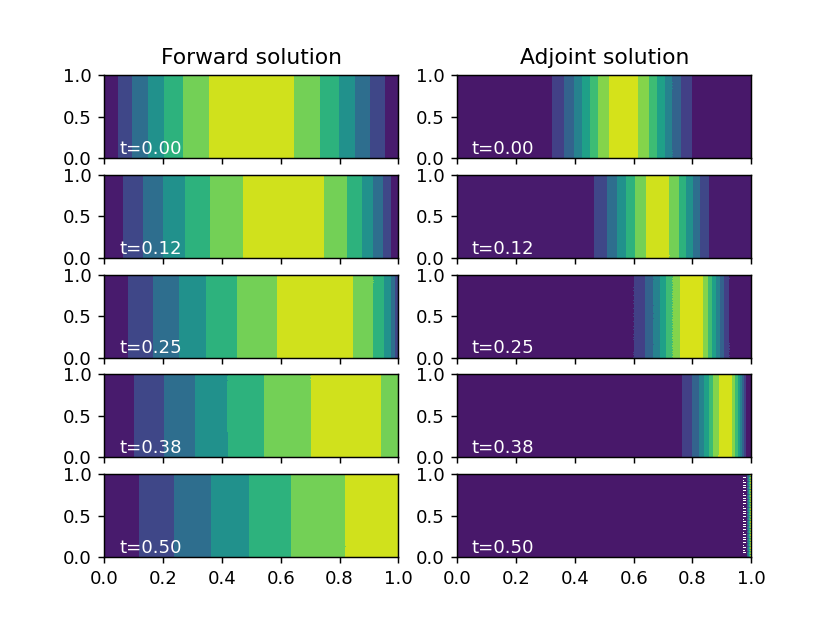

In [12]:
# 'Initial condition' for both adjoint
dJdu = assemble(derivative(J_form, u))

# Plot adjoint solutions at matching timesteps to forward
fig, axs = plt.subplots(num_exports+1, 2, sharex='col')
for i in range(num_exports+1):
    t = i*timesteps_per_export*dt
    tricontourf(forward_solutions[i], axes=axs[i, 0])
    adjoint_solution = dJdu if i == num_exports else solve_blocks[timesteps_per_export*i].adj_sol
    tricontourf(adjoint_solution, axes=axs[i, 1])
    axs[i, 0].annotate('t={:.2f}'.format(t), (0.05, 0.05), color='white');
    axs[i, 1].annotate('t={:.2f}'.format(t), (0.05, 0.05), color='white');

# Plot formatting
axs[0, 0].set_title('Forward solution');
axs[0, 1].set_title('Adjoint solution');